# Uniejewski 2023 - reproduction
* B. Uniejewski, "Smoothing Quantile Regression Averaging: A new approach to probabilistic forecasting of electricity prices"
* two out of four datasets
    * EPEX (Germany)
    * OMIE (Spain)

In [1]:
import datetime as dt
import pandas as pd
import numpy as np

## #1 Data downloading

In [ ]:
from remodels.data.EntsoeApi import EntsoeApi

start_date = dt.date(2015, 1, 1)
end_date = dt.date(2023, 7, 1)

security_token = "7032e795-c8ae-4a50-aac8-a377b64b1c9e"
entsoeApi = EntsoeApi(security_token)

### #1.1 Germany

In [ ]:
prices_1 = entsoeApi.get_day_ahead_pricing(
    start_date,
    end_date,
    in_domain="10Y1001A1001A63L",
    resolution_preference=60,
)
prices_2 = entsoeApi.get_day_ahead_pricing(
    start_date,
    end_date,
    in_domain="10Y1001A1001A82H",
    resolution_preference=60,
)
prices = pd.concat([prices_1, prices_2])

forecast_load_1 = entsoeApi.get_forecast_load(start_date, end_date, "10Y1001A1001A63L")
forecast_load_2 = entsoeApi.get_forecast_load(start_date, end_date, "10Y1001A1001A82H")
forecast_load_1 = forecast_load_1.resample("H").mean()
forecast_load_2 = forecast_load_2.resample("H").mean()
forecast_load = pd.concat([forecast_load_1, forecast_load_2])

#
germany_data = prices.join(forecast_load)
germany_data.to_csv("germany_data.csv")

### #1.2 Spain

In [ ]:
prices_spain = entsoeApi.get_day_ahead_pricing(
    start_date, end_date, "10YES-REE------0", resolution_preference=60
)
forecast_load_spain = entsoeApi.get_forecast_load(
    start_date, end_date, "10YES-REE------0"
)
forecast_load_spain = forecast_load_spain.resample("H").mean()
spain_data = prices_spain.join(forecast_load_spain)
spain_data.to_csv("spain_data.csv")

## #2 Point prediction model

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from remodels.pipelines.RePipeline import RePipeline
from remodels.pointsModels import PointModel
from remodels.transformers.DSTAdjuster import DSTAdjuster
from remodels.transformers.StandardizingScaler import StandardizingScaler
from remodels.transformers.VSTransformers import ArcsinhScaler
from remodels.transformers.VSTransformers import BoxCoxScaler
from remodels.transformers.VSTransformers import PITScaler
from remodels.transformers.VSTransformers import MLogScaler
from remodels.transformers.VSTransformers import PolyScaler

In [9]:
def prepare_for_points_models(data):
    data = DSTAdjuster().fit_transform(data)
    data = data.rename(columns={"quantity": "load"})
    # autoregressive effects a
    data["price_da_1D"] = data["price_da"].shift(24)
    data["price_da_2D"] = data["price_da"].shift(2 * 24)
    data["price_da_7D"] = data["price_da"].shift(7 * 24)
    # end-of-day
    data["price_da_23_1D"] = data.resample("D")["price_da"].transform("last").shift(24)
    # non-linear effects
    data["min_price_da_1D"] = data["price_da_1D"].resample("D").transform("min")
    data["max_price_da_1D"] = data["price_da_1D"].resample("D").transform("max")

    weekday_dummies = pd.get_dummies(data.index.weekday, prefix="weekday")
    weekday_dummies.index = data.index
    weekday_dummies = weekday_dummies.astype(int)
    data = pd.concat([data, weekday_dummies], axis=1)
    return data

In [10]:
X_cols_to_pipeline = [
    "price_da_1D",
    "price_da_2D",
    "price_da_7D",
    "price_da_23_1D",
    "max_price_da_1D",
    "min_price_da_1D",
    "load",
]
X_cols_dummy = [
    "weekday_0",
    "weekday_1",
    "weekday_2",
    "weekday_3",
    "weekday_4",
    "weekday_5",
    "weekday_6",
]
X_cols = X_cols_to_pipeline + X_cols_dummy
y_column = "price_da"

variables_per_hour = {(0, 24): X_cols}

start = dt.date(2016, 12, 29)
end = dt.date(2020, 1, 10)

### #2.1 Germany - points models

In [11]:
germany_data = pd.read_csv("germany_data.csv", index_col=0, parse_dates=True)
germany_data = prepare_for_points_models(germany_data)

In [12]:
# Arcsinh
pipeline = RePipeline(
    [
        ("standardScaler", StandardizingScaler()),
        ("vstScaler", ArcsinhScaler()),
        ("linearRegression", LinearRegression()),
    ]
)
pointModel = PointModel(
    pipeline=pipeline,
    variables_per_hour=variables_per_hour,
    y_column=y_column,
)
pointModel.fit(germany_data, start=start, end=end)
arcsinh_point_prediction_728 = pointModel.predict(
    rolling_window=728, inverse_predictions=True
)

# BoxCox
pipeline = RePipeline(
    [
        ("standardScaler", StandardizingScaler()),
        ("vstScaler", BoxCoxScaler()),
        ("LinearRegression", LinearRegression()),
    ]
)
pointModel = PointModel(
    pipeline=pipeline,
    variables_per_hour=variables_per_hour,
    y_column=y_column,
)
pointModel.fit(germany_data, start=start, end=end)
boxCox_point_prediction_728 = pointModel.predict(
    rolling_window=728, inverse_predictions=True
)

# MlogScaler
pipeline = RePipeline(
    [
        ("standardScaler", StandardizingScaler()),
        ("vstScaler", MLogScaler()),
        ("LinearRegression", LinearRegression()),
    ]
)
pointModel = PointModel(
    pipeline=pipeline,
    variables_per_hour=variables_per_hour,
    y_column=y_column,
)
pointModel.fit(germany_data, start=start, end=end)
mlog_point_prediction_728 = pointModel.predict(
    rolling_window=728, inverse_predictions=True
)

# PolyScaler
pipeline = RePipeline(
    [
        ("standardScaler", StandardizingScaler()),
        ("vstScaler", PolyScaler()),
        ("LinearRegression", LinearRegression()),
    ]
)
pointModel = PointModel(
    pipeline=pipeline,
    variables_per_hour=variables_per_hour,
    y_column=y_column,
)
pointModel.fit(germany_data, start=start, end=end)
poly_point_prediction_728 = pointModel.predict(
    rolling_window=728, inverse_predictions=True
)

# NPit
pipeline = RePipeline(
    [("vstScaler", PITScaler()), ("LinearRegression", LinearRegression())]
)
pointModel = PointModel(
    pipeline=pipeline,
    variables_per_hour=variables_per_hour,
    y_column=y_column,
)
pointModel.fit(germany_data, start=start, end=end)
pit_point_prediction_728 = pointModel.predict(
    rolling_window=728, inverse_predictions=True
)

In [13]:
germany_data["arcsinh_points_pred"] = arcsinh_point_prediction_728
germany_data["boxCox_points_pred"] = boxCox_point_prediction_728
germany_data["mLog_points_pred"] = mlog_point_prediction_728
germany_data["poly_points_pred"] = poly_point_prediction_728
germany_data["npit_points_pred"] = pit_point_prediction_728
germany_data.to_csv("germany_data_after_points.csv")

In [15]:
def get_points_prediction_summary(data_prediction):
    data_prediction=data_prediction.filter(regex="points|^price_da$").dropna()
    prediction_columns = data_prediction.filter(regex="points").columns
    metrics = pd.DataFrame(index=prediction_columns, columns=["MAE", "MSE", "R2", "RMSE"])
    for column in prediction_columns:
        actual = data_prediction["price_da"]
        predicted = data_prediction[column]

        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        rmse = np.sqrt(mse)

        metrics.loc[column] = [mae, mse, r2, rmse]
    return metrics


get_points_prediction_summary(germany_data.loc["2016-12-20":"2019-12-31"] )

,MAE,MSE,R2,RMSE
arcsinh_points_pred,6.037069,90.971085,0.691322,9.537876
boxCox_points_pred,6.048451,90.270047,0.693701,9.501055
mLog_points_pred,6.04593,90.364554,0.69338,9.506027
poly_points_pred,6.051455,90.338002,0.69347,9.504631
npit_points_pred,6.239463,109.208015,0.629442,10.450264


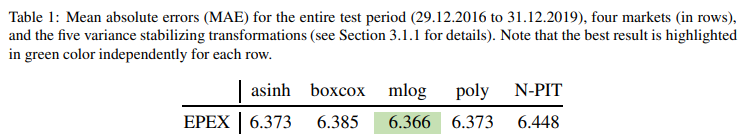

### 2.2 Spain

In [18]:
spain_data = pd.read_csv("spain_data.csv", index_col=0, parse_dates=True)
spain_data = prepare_for_points_models(spain_data)

In [19]:
# Arcsinh
pipeline = RePipeline(
    [
        ("standardScaler", StandardizingScaler()),
        ("vstScaler", ArcsinhScaler()),
        ("linearRegression", LinearRegression()),
    ]
)
pointModel = PointModel(
    pipeline=pipeline,
    variables_per_hour=variables_per_hour,
    y_column=y_column,
)

pointModel.fit(spain_data, start=start, end=end)
arcsinh_point_prediction_728 = pointModel.predict(
    rolling_window=728, inverse_predictions=True
)

# BoxCox
pipeline = RePipeline(
    [
        ("standardScaler", StandardizingScaler()),
        ("vstScaler", BoxCoxScaler()),
        ("LinearRegression", LinearRegression()),
    ]
)
pointModel = PointModel(
    pipeline=pipeline,
    variables_per_hour=variables_per_hour,
    y_column=y_column,
)

pointModel.fit(spain_data, start=start, end=end)
boxCox_point_prediction_728 = pointModel.predict(
    rolling_window=728, inverse_predictions=True
)

# MlogScaler
pipeline = RePipeline(
    [
        ("standardScaler", StandardizingScaler()),
        ("vstScaler", MLogScaler()),
        ("LinearRegression", LinearRegression()),
    ]
)
pointModel = PointModel(
    pipeline=pipeline,
    variables_per_hour=variables_per_hour,
    y_column=y_column,
)
pointModel.fit(spain_data, start=start, end=end)
mlog_point_prediction_728 = pointModel.predict(
    rolling_window=728, inverse_predictions=True
)

# PolyScaler
pipeline = RePipeline(
    [
        ("standardScaler", StandardizingScaler()),
        ("vstScaler", PolyScaler()),
        ("LinearRegression", LinearRegression()),
    ]
)
pointModel = PointModel(
    pipeline=pipeline,
    variables_per_hour=variables_per_hour,
    y_column=y_column,
)
pointModel.fit(spain_data, start=start, end=end)
poly_point_prediction_728 = pointModel.predict(
    rolling_window=728, inverse_predictions=True
)

# NPit
pipeline = RePipeline(
    [("vstScaler", PITScaler()), ("LinearRegression", LinearRegression())]
)
pointModel = PointModel(
    pipeline=pipeline,
    variables_per_hour=variables_per_hour,
    y_column=y_column,
)
pointModel.fit(spain_data, start=start, end=end)
pit_point_prediction_728 = pointModel.predict(
    rolling_window=728, inverse_predictions=True
)

In [20]:
spain_data["arcsinh_points_pred"] = arcsinh_point_prediction_728
spain_data["boxCox_points_pred"] = boxCox_point_prediction_728
spain_data["mLog_points_pred"] = mlog_point_prediction_728
spain_data["poly_points_pred"] = poly_point_prediction_728
spain_data["npit_points_pred"] = pit_point_prediction_728
spain_data.to_csv("spain_data_after_points.csv")

In [26]:
get_points_prediction_summary(spain_data.loc["2016-12-29":"2019-12-31"])

,MAE,MSE,R2,RMSE
arcsinh_points_pred,3.59423,26.236429,0.835707,5.122151
boxCox_points_pred,3.582737,25.89203,0.837864,5.088421
mLog_points_pred,3.583339,25.914177,0.837725,5.090597
poly_points_pred,3.585838,25.918077,0.837701,5.09098
npit_points_pred,3.703961,27.726664,0.826375,5.265611


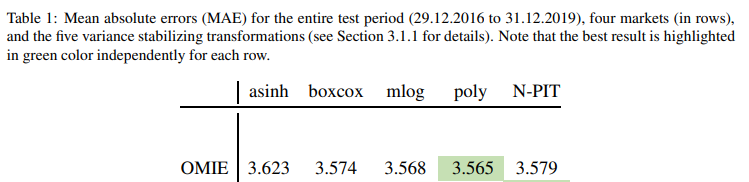

## #3 QR* models

In [4]:
from remodels.qra import QRA
from remodels.qra import QRM
from remodels.qra import SQRA
from remodels.qra import SQRM
from remodels.qra import QR_ResultsSummary
from remodels.qra import QR_Tester
from remodels.qra import QR_TestResults
from remodels.qra import f_ave

### #3.1 Germany - QR* models

In [ ]:
germany_data = pd.read_csv("germany_data_after_points.csv", index_col=0)
germany_data = germany_data.loc["2016-12-29 00:00:00":"2019-12-31 24:00:00"].dropna()

y = germany_data["price_da"].to_numpy()
arcsinh_points_pred = germany_data[["arcsinh_points_pred"]].to_numpy()
boxCox_points_pred = germany_data[["boxCox_points_pred"]].to_numpy()
mLog_points_pred = germany_data[["mLog_points_pred"]].to_numpy()
poly_points_pred = germany_data[["poly_points_pred"]].to_numpy()
npit_points_pred = germany_data[["npit_points_pred"]].to_numpy()
points_pred = germany_data.filter(like="points_pred").to_numpy()

In [ ]:
kwargs_ = {
    "calibration_window": 182 * 24,
    "prediction_window": 24,
    "multivariate": True,
}

# qra
qra_prob = QR_Tester(**kwargs_, qr_model=QRA(fit_intercept=True)).fit_predict(points_pred, y)
qrm_prob = QR_Tester(**kwargs_, qr_model=QRM(fit_intercept=True)).fit_predict(points_pred, y)
qra_arcsinh_prob = QR_Tester(**kwargs_, qr_model=QRA(fit_intercept=True)).fit_predict(arcsinh_points_pred, y)
qra_boxCox_prob = QR_Tester(**kwargs_, qr_model=QRA(fit_intercept=True)).fit_predict(boxCox_points_pred, y)
qra_mLog_prob = QR_Tester(**kwargs_, qr_model=QRA(fit_intercept=True)).fit_predict(mLog_points_pred, y)
qra_poly_prob = QR_Tester(**kwargs_, qr_model=QRA(fit_intercept=True)).fit_predict(poly_points_pred, y)
qra_npit_prob = QR_Tester(**kwargs_, qr_model=QRA(fit_intercept=True)).fit_predict(npit_points_pred, y)
qra_f_ave = f_ave(qra_arcsinh_prob, qra_boxCox_prob, qra_mLog_prob, qra_poly_prob, qra_npit_prob)

qra_prob.to_pickle("germany/qra.pkl")
qrm_prob.to_pickle("germany/qrm.pkl")
qra_f_ave.to_pickle("germany/qra_f_ave.pkl")

# sqra
sqra_prob = QR_Tester(**kwargs_, qr_model=SQRA(fit_intercept=True)).fit_predict(points_pred, y)
sqrm_prob = QR_Tester(**kwargs_, qr_model=SQRM(fit_intercept=True)).fit_predict(points_pred, y)
sqra_arcsinh_prob = QR_Tester(**kwargs_, qr_model=SQRA(fit_intercept=True)).fit_predict(arcsinh_points_pred, y)
sqra_boxCox_prob = QR_Tester(**kwargs_, qr_model=SQRA(fit_intercept=True)).fit_predict(boxCox_points_pred, y)
sqra_mLog_prob = QR_Tester(**kwargs_, qr_model=SQRA(fit_intercept=True)).fit_predict(mLog_points_pred, y)
sqra_poly_prob = QR_Tester(**kwargs_, qr_model=SQRA(fit_intercept=True)).fit_predict(poly_points_pred, y)
sqra_npit_prob = QR_Tester(**kwargs_, qr_model=SQRA(fit_intercept=True)).fit_predict(npit_points_pred, y)
sqra_f_ave = f_ave(sqra_arcsinh_prob, sqra_boxCox_prob, sqra_mLog_prob, sqra_poly_prob, sqra_npit_prob)

sqra_prob.to_pickle("germany/sqra.pkl")
sqrm_prob.to_pickle("germany/sqrm.pkl")
sqra_f_ave.to_pickle("germany/sqra_f_ave.pkl")

### #3.2 Spain - QR* models

In [ ]:
spain_data = pd.read_csv("spain_data_after_points.csv", index_col=0)
spain_data = spain_data.loc["2016-12-29 00:00:00":"2019-12-31 24:00:00"].dropna()

y = spain_data["price_da"].to_numpy()
arcsinh_points_pred = spain_data[["arcsinh_points_pred"]].to_numpy()
boxCox_points_pred = spain_data[["boxCox_points_pred"]].to_numpy()
mLog_points_pred = spain_data[["mLog_points_pred"]].to_numpy()
poly_points_pred = spain_data[["poly_points_pred"]].to_numpy()
npit_points_pred = spain_data[["npit_points_pred"]].to_numpy()
points_pred = spain_data.filter(like="points_pred").to_numpy()

In [ ]:
kwargs_ = {
    "calibration_window": 182 * 24,
    "prediction_window": 24,
    "multivariate": True,
}

# qra
qra_prob = QR_Tester(**kwargs_, qr_model=QRA(fit_intercept=True)).fit_predict(points_pred, y)
qrm_prob = QR_Tester(**kwargs_, qr_model=QRM(fit_intercept=True)).fit_predict(points_pred, y)
qra_arcsinh_prob = QR_Tester(**kwargs_, qr_model=QRA(fit_intercept=True)).fit_predict(arcsinh_points_pred, y)
qra_boxCox_prob = QR_Tester(**kwargs_, qr_model=QRA(fit_intercept=True)).fit_predict(boxCox_points_pred, y)
qra_mLog_prob = QR_Tester(**kwargs_, qr_model=QRA(fit_intercept=True)).fit_predict(mLog_points_pred, y)
qra_poly_prob = QR_Tester(**kwargs_, qr_model=QRA(fit_intercept=True)).fit_predict(poly_points_pred, y)
qra_npit_prob = QR_Tester(**kwargs_, qr_model=QRA(fit_intercept=True)).fit_predict(npit_points_pred, y)
qra_f_ave = f_ave(qra_arcsinh_prob, qra_boxCox_prob, qra_mLog_prob, qra_poly_prob, qra_npit_prob)

qra_prob.to_pickle("spain/qra.pkl")
qrm_prob.to_pickle("spain/qrm.pkl")
qra_f_ave.to_pickle("spain/qra_f_ave.pkl")

# sqra
sqra_prob = QR_Tester(**kwargs_, qr_model=SQRA(fit_intercept=True)).fit_predict(points_pred, y)
sqrm_prob = QR_Tester(**kwargs_, qr_model=SQRM(fit_intercept=True)).fit_predict(points_pred, y)
sqra_arcsinh_prob = QR_Tester(**kwargs_, qr_model=SQRA(fit_intercept=True)).fit_predict(arcsinh_points_pred, y)
sqra_boxCox_prob = QR_Tester(**kwargs_, qr_model=SQRA(fit_intercept=True)).fit_predict(boxCox_points_pred, y)
sqra_mLog_prob = QR_Tester(**kwargs_, qr_model=SQRA(fit_intercept=True)).fit_predict(mLog_points_pred, y)
sqra_poly_prob = QR_Tester(**kwargs_, qr_model=SQRA(fit_intercept=True)).fit_predict(poly_points_pred, y)
sqra_npit_prob = QR_Tester(**kwargs_, qr_model=SQRA(fit_intercept=True)).fit_predict(npit_points_pred, y)
sqra_f_ave = f_ave(sqra_arcsinh_prob, sqra_boxCox_prob, sqra_mLog_prob, sqra_poly_prob, sqra_npit_prob)

sqra_prob.to_pickle("spain/sqra.pkl")
sqrm_prob.to_pickle("spain/sqrm.pkl")
sqra_f_ave.to_pickle("spain/sqra_f_ave.pkl")

### #3.3 QR* models results

In [5]:
results_dict = {
    "EPEX": {
        "QRA": QR_TestResults.read_pickle("results/germany/qra.pkl"),
        "QRM": QR_TestResults.read_pickle("results/germany/qrm.pkl"),
        "QRA F-Ave": QR_TestResults.read_pickle("results/germany/qra_f_ave.pkl"),
        "SQRA": QR_TestResults.read_pickle("results/germany/sqra.pkl"),
        "SQRM": QR_TestResults.read_pickle("results/germany/sqrm.pkl"),
        "SQRA F-AVE": QR_TestResults.read_pickle("results/germany/sqra_f_ave.pkl"),
    },
    "OMIE": {
        "QRA": QR_TestResults.read_pickle("results/spain/qra.pkl"),
        "QRM": QR_TestResults.read_pickle("results/spain/qrm.pkl"),
        "QRA F-Ave": QR_TestResults.read_pickle("results/spain/qra_f_ave.pkl"),
        "SQRA": QR_TestResults.read_pickle("results/spain/sqra.pkl"),
        "SQRM": QR_TestResults.read_pickle("results/spain/sqrm.pkl"),
        "SQRA F-AVE": QR_TestResults.read_pickle("results/spain/sqra_f_ave.pkl"),
    }
}

qr_summary = QR_ResultsSummary(results_dict)

#### 3.3.1 Average empirical coverage

In [6]:
qr_summary.aec([50, 70, 90])

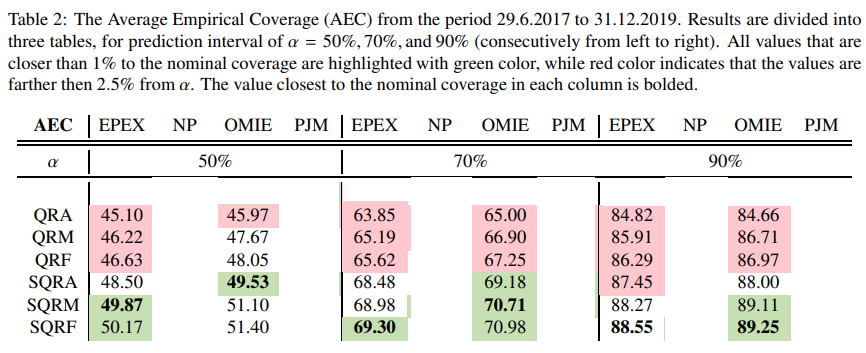

#### #3.3.2 Kupiec test

In [7]:
qr_summary.kupiec_test([50, 70, 90])

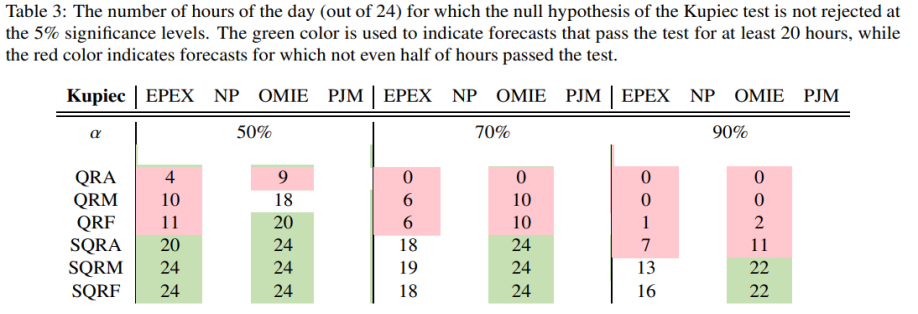

#### #3.3.3 Aggregate pinball score

In [8]:
qr_summary.aps()

,EPEX,OMIE
QRA,2.325,1.331
QRM,2.271,1.318
QRA F-Ave,2.258,1.315
SQRA,2.321,1.329
SQRM,2.267,1.316
SQRA F-AVE,2.259,1.315


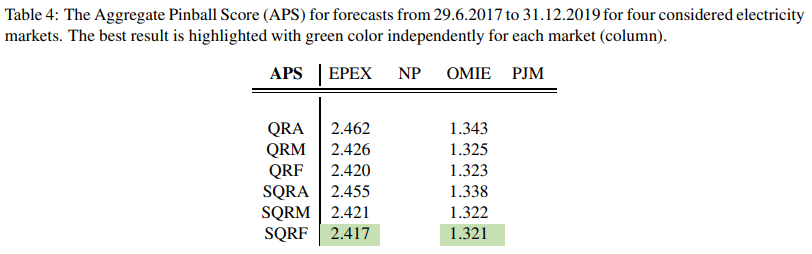

#### 3.3.4. Aggregate pinball score - extreme quantiles

In [9]:
qr_summary.aps_extreme_quantiles(n_quantiles=5)

,EPEX,OMIE
QRA,0.785,0.399
QRM,0.752,0.385
QRA F-Ave,0.728,0.380
SQRA,0.772,0.392
SQRM,0.737,0.380
SQRA F-AVE,0.720,0.378


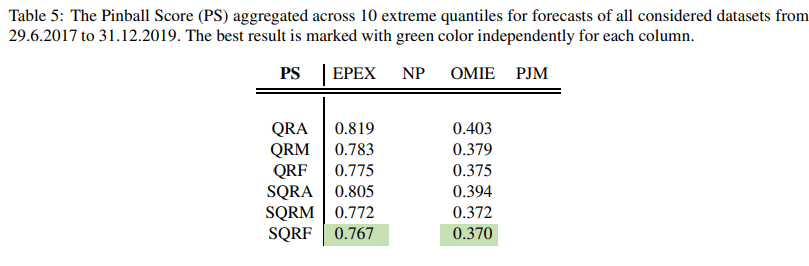